In [1]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt
from scipy.stats import t, normaltest, bartlett, levene
from pingouin import anova
from pingouin import welch_anova
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

In [2]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [3]:
origin = load_data('tips')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확이 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/tips.xlsx
[desc] 식당 고객의 결제 금액, 팁, 성별, 흡연 여부, 요일, 시간대, 일행 규모 등 기본 정보를 담은 데이터 분석·시각화 실습용 샘플 데이터 (출처: https://www.kaggle.com/datasets/sakshisatre/tips-dataset)

field       description
----------  -------------
total_bill  총 결제 금액
tip         팁 금액
sex         성별
smoker      흡연 여부
day         방문 요일
time        방문 시간대
size        일행 규모


===== 데이터 크기 확인 =====
데이터셋 크기: (244, 7)
열 개수: 7
행 개수: 244

===== 타입확이 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB
None


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
df = origin[(origin['day'] == 'Fri')| (origin['day'] == 'Sat')|(origin['day'] == 'Sun')]
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


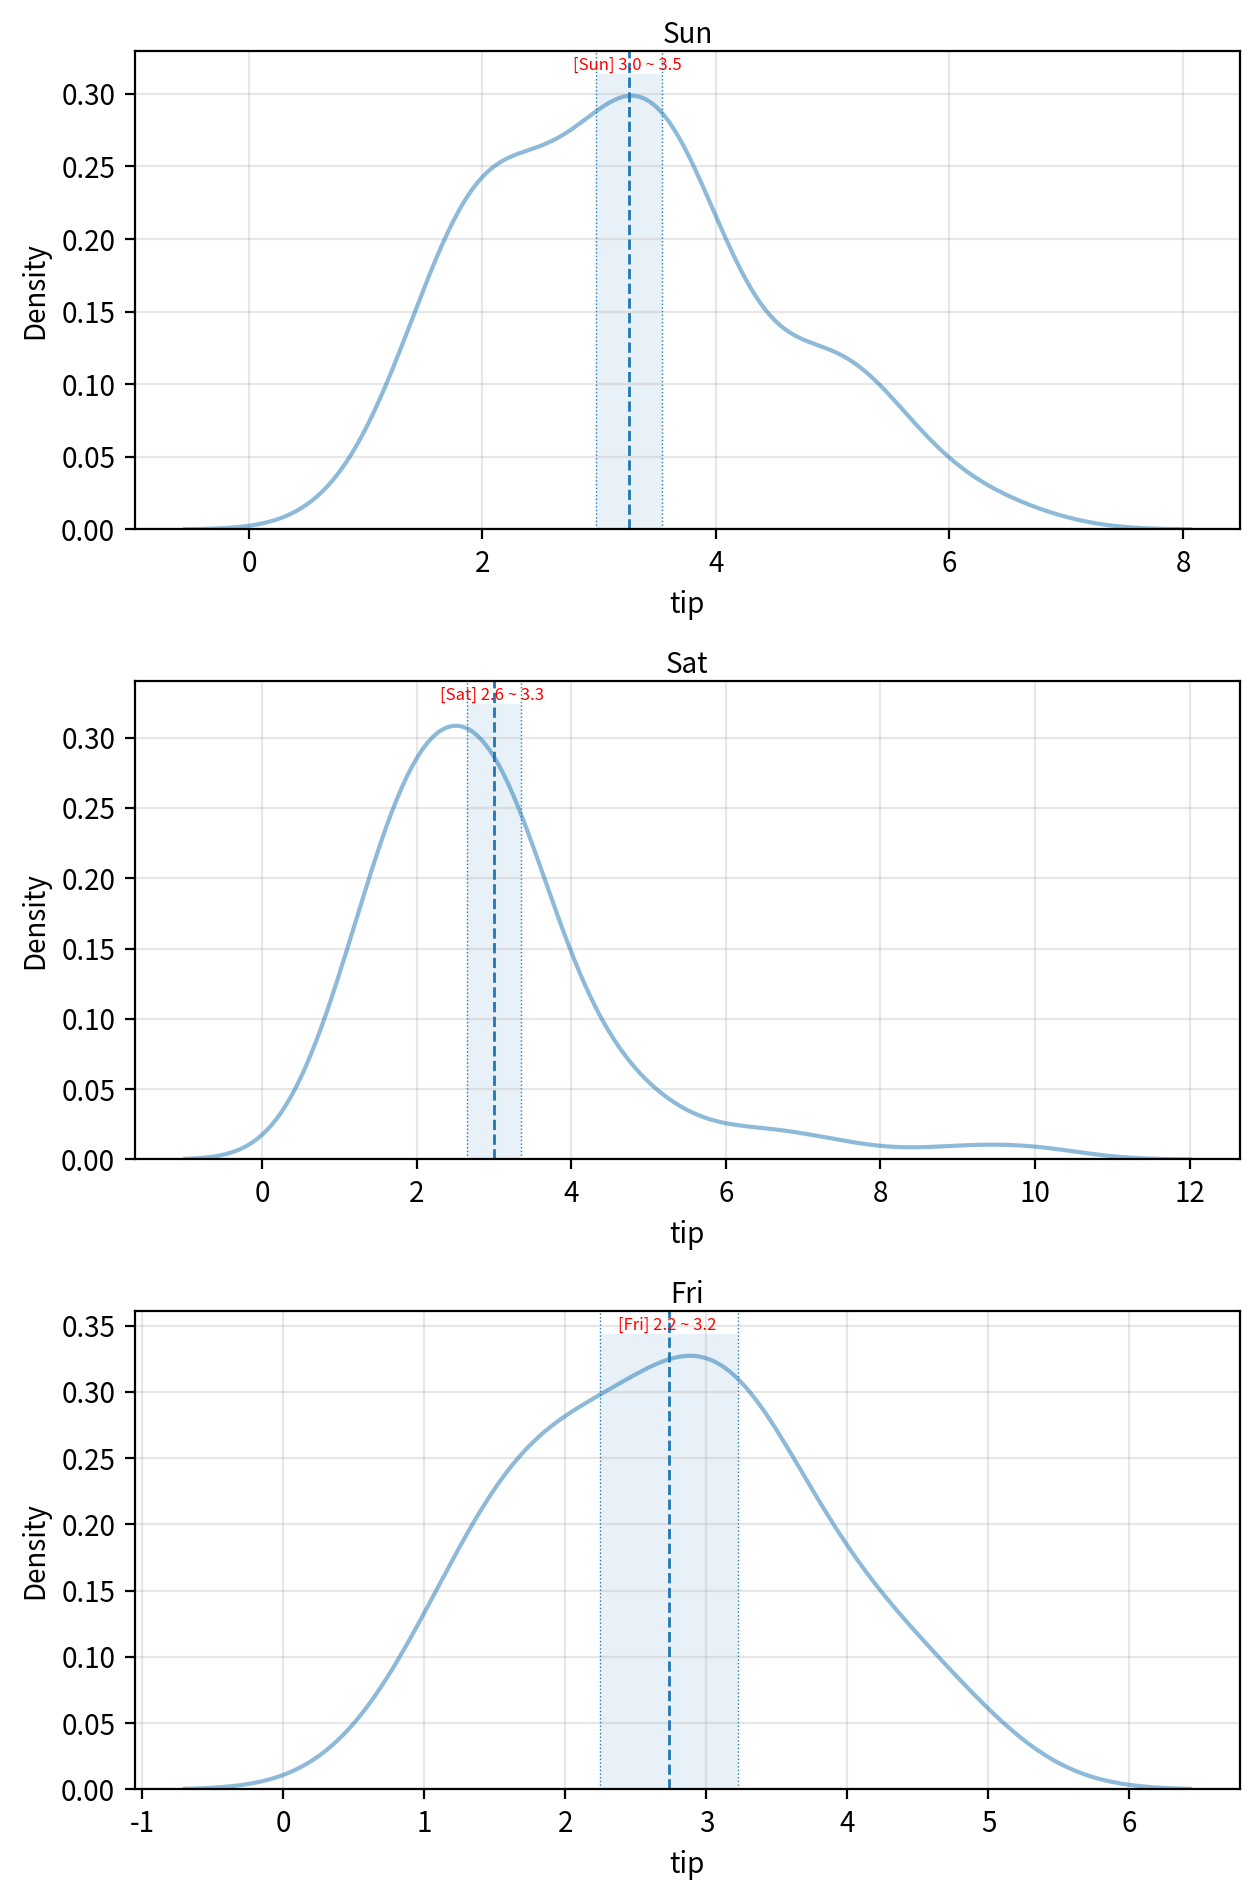

In [11]:
field = 'tip'

hue_field = 'day'

hue_values = df[hue_field].unique()
hue_count = len(hue_values)

width_px = 1280
height_px = 640 *3
rows = 3
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

for i,v in enumerate(hue_values):
    temp = df[df[hue_field] == v]
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)


    max = temp[field].max()
    clevel = 0.95
    dof = len(temp[field]) - 1
    sp_mean = temp[field].mean()
    sp_std = temp[field].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(temp[field]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax,
            s="[%s] %0.1f ~ %0.1f " % (v, cmin, cmax), horizontalalignment="center",
            verticalalignment="bottom",fontdict={"size":6, "color":"red"})


plt.tight_layout()
plt.show()
plt.close()


인사이트
1. 모든 요일에서 KDE는 완만한 종 모양이며 오른쪽 꼬리가 약간 긴 형태를 보인다.
극단적으로 큰 팁이 가끔 등장하지만 대부분은 낮은 값에 집중되어 있다는 의미.
2. 요일별 평균은 KDE의 최고점(최빈값)보다 약간 오른쪽에 있으며 Sun> Sat> Fri순으로 높게 나타난다.
평균 팁은 일요일이 가장 높고 금요일이 가장 낮다.
3. 신뢰구간의 폭:주말은 팁 금액 변화가 크고, 금요일은 비교적 안정적으로 낮은 팁이 발생한다.
Sun 과 Sat은 폭이 더 넓음-> 팁 변동성이 크다
Fri는 폭이 좁음-> 팁 금액이 비교적 일정하다.

In [6]:
groups = [(name, grp['tip'])for name, grp in df.groupby('day')]


report = []
normal_dist = True

for name,series in groups:
    stat,p = normaltest(series)
    ok = p>0.05
    report.append({"field":name, "statistic":stat, "p-value":p,"result":ok})
    normal_dist = normal_dist and ok


if normal_dist:
    
        testname = "Bartlett"

        stat,p = bartlett(*[s.values for _, s in groups])

else:
    test_name = "Levene"

    stat,p = levene(*[s.values for  _, s in groups], center="median")
       
equal_var = p>0.05
report.append({"field": test_name, "statistic":stat, "p-value":p, "result":equal_var})

report_df =DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
Fri,0.416676,8.119325e-01,True
Sat,49.144308,2.130341e-11,False
Sun,3.396232,1.830280e-01,True
Levene,0.651391,5.225516e-01,True


In [7]:
anova_df = origin[['tip', 'day']].copy()
anova_df

,tip,day
0,1.01,Sun
1,1.66,Sun
2,3.50,Sun
3,3.31,Sun
4,3.61,Sun
...,...,...
239,5.92,Sat
240,2.00,Sat
241,2.00,Sat
242,1.75,Sat


In [8]:
if equal_var:
    pg_anova = anova(data=anova_df, dv='tip', between='day')

else:
    pg_anova = welch_anova(data=anova_df, dv='tip', between='day')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,day,3,240,1.672355,0.173589,0.020476


In [9]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")

'statistic: 1.672, p-value: 0.174, 귀무가설 채택'

세 요일(금,토,일)간 평균 팁 금액의 차이를 검정한 결과, 유의수준 0.05 기준에서 통계적으로 유의한 차이는 확인되지 않았다.
요일이 팁 금액 차이에 유의한 영향을 주지 않는것으로 판단된다.

In [10]:
if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=anova_df, dv='tip', between='day')
else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(anova_df, dv='tip', between='day')
    
hoc_df

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Fri,Sat,2.734737,2.993103,-0.258367,0.348935,-0.740444,0.880645,-0.166274
1,Fri,Sun,2.734737,3.255132,-0.520395,0.353432,-1.472405,0.455805,-0.431509
2,Fri,Thur,2.734737,2.771452,-0.036715,0.361324,-0.101612,0.999623,-0.030468
3,Sat,Sun,2.993103,3.255132,-0.262028,0.216349,-1.211136,0.620382,-0.178644
4,Sat,Thur,2.993103,2.771452,0.221652,0.229016,0.967846,0.767858,0.148857
5,Sun,Thur,3.255132,2.771452,0.483680,0.235811,2.051132,0.172421,0.388762


모든 요일 쌍에서 p-tukey>0.05로 나타나, Fri*Sat*Sun*Thur 간 평균 팁 금액의 유의한 차이는 발견되지 않았다.
Fri와 Sat, Fri와Sun, Fri와Thur 비교에서 평균 차이가 존재하더라도 통계적으로 유의 하지 않았으며, 이는 표본 내 자연스러운 변동 범위로 볼 수 있다.
Sat 과 Sun 비교에서도 Sat이 약간 낮은 경향이 있으나, p = 0.620으로 차이가 유의하지 않다.
Sun 과 Thur 비교는 diff=0.48로 가장 큰 평균 차이가 있었지만(p=0.172)통계적 기준을 충족하지 못해 유의한 차이라고 볼 수 없다.